<a href="https://colab.research.google.com/github/GonzaloPerezGomez/Pytorch/blob/main/02_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02- Neural Network classification with PyTorch

Predicting whether something is one thing of another

## 1. Make classification data

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Make circles
X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)



In [2]:
X[:5], y[:5], len(X[0])

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]),
 2)

In [3]:
# Make a DataFrame
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


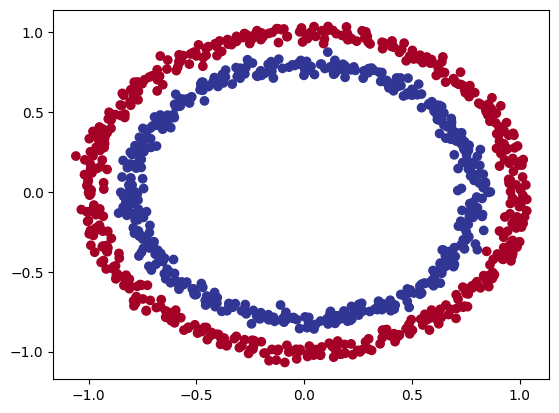

In [4]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
             y=X[:, 1],
             c=y,
             cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X[0], y[0]

(array([0.75424625, 0.23148074]), np.int64(1))

### 1.2 Turn data into tensors and create train and test splits

In [7]:
# Turn data into tensors
import torch

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[0], y[0]

(tensor([0.7542, 0.2315]), tensor(1.))

In [9]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Build a model to classify our blue and red torch.DoubleTensor
To do so:
1. Setup devise agnostic Code
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and lest loop

In [11]:
import torch
from torch import nn

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
# Subclass nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                            out_features=5)

    self.layer_2 = nn.Linear(in_features=5,
                            out_features=1)

  # Defines a forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# Instantiate an instance of our model class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Simpler way to do it nn.Sequential()
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)).to(device)

model_0, model_0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[ 0.2076,  0.4834],
                       [ 0.3957,  0.4752],
                       [ 0.0518,  0.1151],
                       [ 0.1355,  0.3640],
                       [-0.1275, -0.0150]])),
              ('0.bias',
               tensor([-0.6813, -0.4730, -0.5301, -0.0500, -0.2621])),
              ('1.weight',
               tensor([[ 0.0242, -0.4467, -0.2443,  0.3092,  0.3885]])),
              ('1.bias', tensor([-0.1544]))]))

In [15]:
# Make predictions
with torch.inference_mode():
  untrained_pred = model_0(X_test.to(device))
torch.round(untrained_pred[:5]), y_test[:5]

(tensor([[0.],
         [-0.],
         [0.],
         [-0.],
         [0.]]),
 tensor([1., 0., 1., 0., 1.]))

### 2.1 Setup loss function and optimizer

Which should we use:
Loss function:

* For refression - MAE or MSE

* For classification - binaty cross entropy or categorical cross entropy


For optimizers:

* SGD or Adam


In [16]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Has the sigmoid activation built-in

# Setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [17]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train a model

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels



In [18]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0413],
        [-0.0675],
        [ 0.2259],
        [-0.0106],
        [ 0.0661]])

In [19]:
# Use the sigmoid activation on our model logits to turn them into prediction probabilities
y_pred_prods = torch.sigmoid(y_logits)
y_pred_prods
#>=5 -> class 1
#<5 -> class2

tensor([[0.5103],
        [0.4831],
        [0.5562],
        [0.4974],
        [0.5165]])

In [20]:
#Find the predicted lables
y_preds = torch.round(y_pred_prods)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of the extra dimentions
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.])

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a train and test loop

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):

  ### Trainig
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss/accuracy
  loss = loss_fn(y_logits, # nn_BCEWithLogitsLoss expect raw logits as input
                 y_train)

  acc = accuracy_fn(y_train,
                    y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_test,
                           test_pred)

  if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test_Loss: {test_loss:.5f}, Test_Acc: {test_acc:.2f}%")

Epoch: 0, Loss: 0.69723, Acc: 50.62%, Test_Loss: 0.69153, Test_Acc: 51.50%
Epoch: 10, Loss: 0.69591, Acc: 49.75%, Test_Loss: 0.69143, Test_Acc: 52.50%
Epoch: 20, Loss: 0.69526, Acc: 49.62%, Test_Loss: 0.69159, Test_Acc: 52.00%
Epoch: 30, Loss: 0.69483, Acc: 48.88%, Test_Loss: 0.69178, Test_Acc: 52.50%
Epoch: 40, Loss: 0.69450, Acc: 48.50%, Test_Loss: 0.69196, Test_Acc: 51.50%
Epoch: 50, Loss: 0.69424, Acc: 49.00%, Test_Loss: 0.69213, Test_Acc: 51.50%
Epoch: 60, Loss: 0.69403, Acc: 48.88%, Test_Loss: 0.69230, Test_Acc: 51.00%
Epoch: 70, Loss: 0.69386, Acc: 49.00%, Test_Loss: 0.69247, Test_Acc: 50.00%
Epoch: 80, Loss: 0.69372, Acc: 49.12%, Test_Loss: 0.69263, Test_Acc: 49.00%
Epoch: 90, Loss: 0.69360, Acc: 49.50%, Test_Loss: 0.69279, Test_Acc: 48.50%


## 4. Make predictions and evaluatio the model

From the matric it seems that the model is not learning


In [23]:
import requests
from pathlib import Path

# Download helper funtion from Lean PyTorch
if not Path("help_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("help_functions.py", "wb") as f:
    f.write(request.content)

from help_functions import plot_predictions, plot_decision_boundary

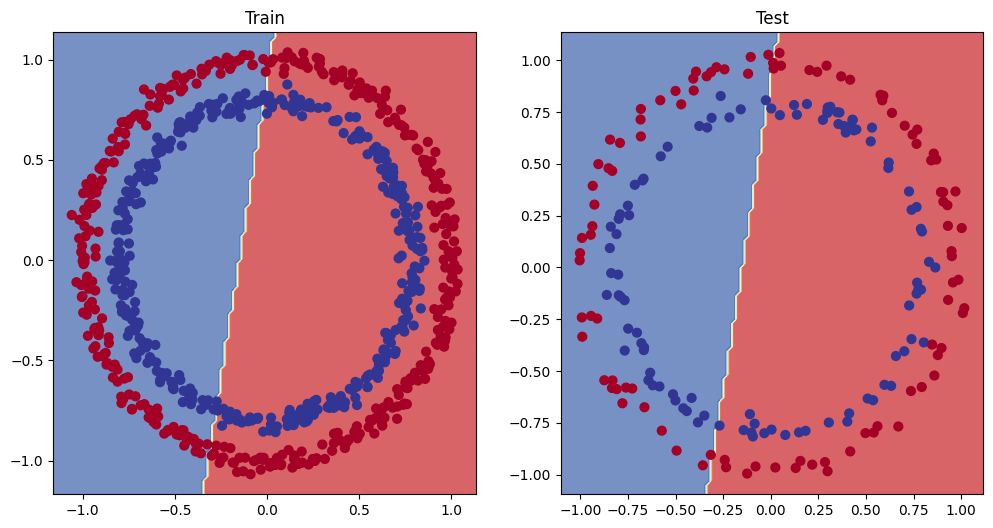

In [24]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

* Add more layers, so he can learn more
* Add more hidden units/neurons per layer
* Fit for longer - more epochs
* Changing the activation function
* Change the learning rate
* Change the loss function

In [25]:
# Improvement by adding layers
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features= 2,
                             out_features= 10)

    self.layer_2 = nn.Linear(in_features= 10,
                             out_features= 10)

    self.layer_3 = nn.Linear(in_features= 10,
                             out_features= 1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

Epoch: 0, Loss: 0.69396, Acc: 50.88%, Test_Loss: 0.69261, Test_Acc: 51.00%
Epoch: 100, Loss: 0.69305, Acc: 50.38%, Test_Loss: 0.69379, Test_Acc: 48.00%
Epoch: 200, Loss: 0.69299, Acc: 51.12%, Test_Loss: 0.69437, Test_Acc: 46.00%
Epoch: 300, Loss: 0.69298, Acc: 51.62%, Test_Loss: 0.69458, Test_Acc: 45.00%
Epoch: 400, Loss: 0.69298, Acc: 51.12%, Test_Loss: 0.69465, Test_Acc: 46.00%
Epoch: 500, Loss: 0.69298, Acc: 51.00%, Test_Loss: 0.69467, Test_Acc: 46.00%
Epoch: 600, Loss: 0.69298, Acc: 51.00%, Test_Loss: 0.69468, Test_Acc: 46.00%
Epoch: 700, Loss: 0.69298, Acc: 51.00%, Test_Loss: 0.69468, Test_Acc: 46.00%
Epoch: 800, Loss: 0.69298, Acc: 51.00%, Test_Loss: 0.69468, Test_Acc: 46.00%
Epoch: 900, Loss: 0.69298, Acc: 51.00%, Test_Loss: 0.69468, Test_Acc: 46.00%


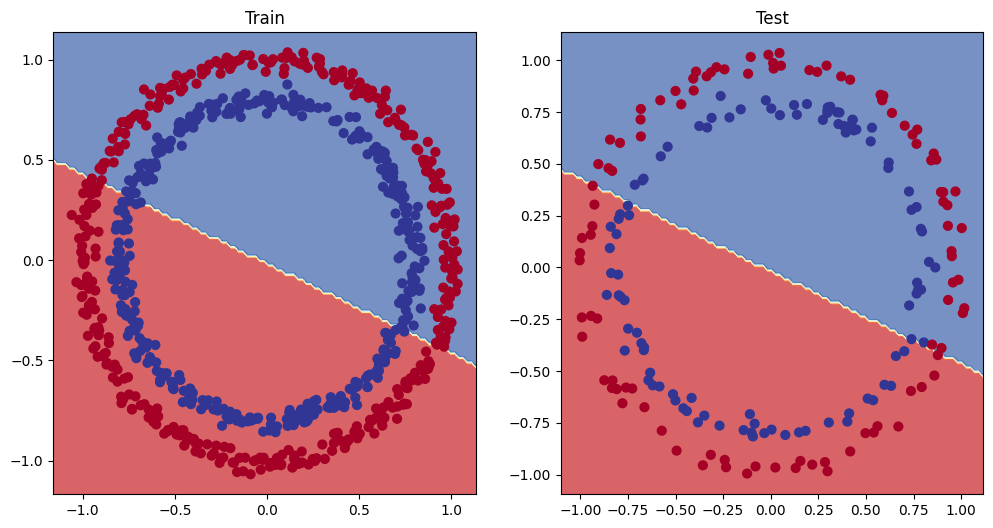

In [26]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr = 0.1)

# Training and test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Train
  model_1.train()

  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_train,
                    y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backwards
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Test
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_test,
                      test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test_Loss: {test_loss:.5f}, Test_Acc: {test_acc:.2f}%")

# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


The modeel doesnt improve because we are using linea funtions (nn.Linear()) but our data is NON-LINEAR

## 6. The missing piece: non-Linearity

### 6.1 Recreating non-Linear data

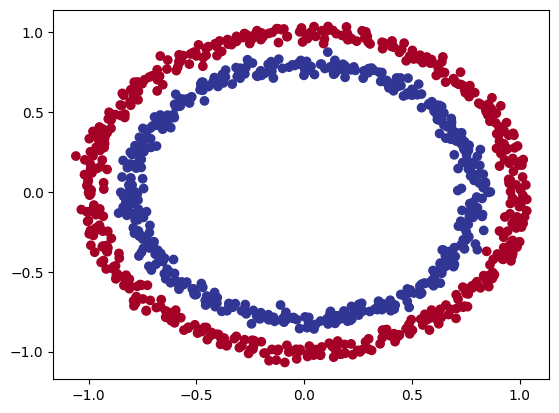

In [27]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Make circles
X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)

import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
             y=X[:, 1],
             c=y,
             cmap=plt.cm.RdYlBu)

In [28]:
import torch
from sklearn.model_selection import train_test_split

In [29]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [30]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(2, 10)
    self.layer_2 = nn.Linear(10, 10)
    self.layer_3 = nn.Linear(10, 1)
    self.relu = nn.ReLU() # Non-Linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Epoch: 0, Loss: 0.69295, Acc: 50.00%, Test_Loss: 0.69325, Test_Acc: 50.00%
Epoch: 1000, Loss: 0.69115, Acc: 53.00%, Test_Loss: 0.69104, Test_Acc: 52.50%
Epoch: 2000, Loss: 0.68977, Acc: 53.37%, Test_Loss: 0.68941, Test_Acc: 55.00%
Epoch: 3000, Loss: 0.68794, Acc: 53.00%, Test_Loss: 0.68725, Test_Acc: 56.00%
Epoch: 4000, Loss: 0.68515, Acc: 52.75%, Test_Loss: 0.68413, Test_Acc: 56.50%
Epoch: 5000, Loss: 0.68100, Acc: 52.75%, Test_Loss: 0.67943, Test_Acc: 56.50%
Epoch: 6000, Loss: 0.67510, Acc: 54.50%, Test_Loss: 0.67287, Test_Acc: 56.00%
Epoch: 7000, Loss: 0.66650, Acc: 58.38%, Test_Loss: 0.66323, Test_Acc: 59.00%
Epoch: 8000, Loss: 0.65140, Acc: 64.00%, Test_Loss: 0.64755, Test_Acc: 67.50%
Epoch: 9000, Loss: 0.62316, Acc: 74.00%, Test_Loss: 0.62137, Test_Acc: 79.00%


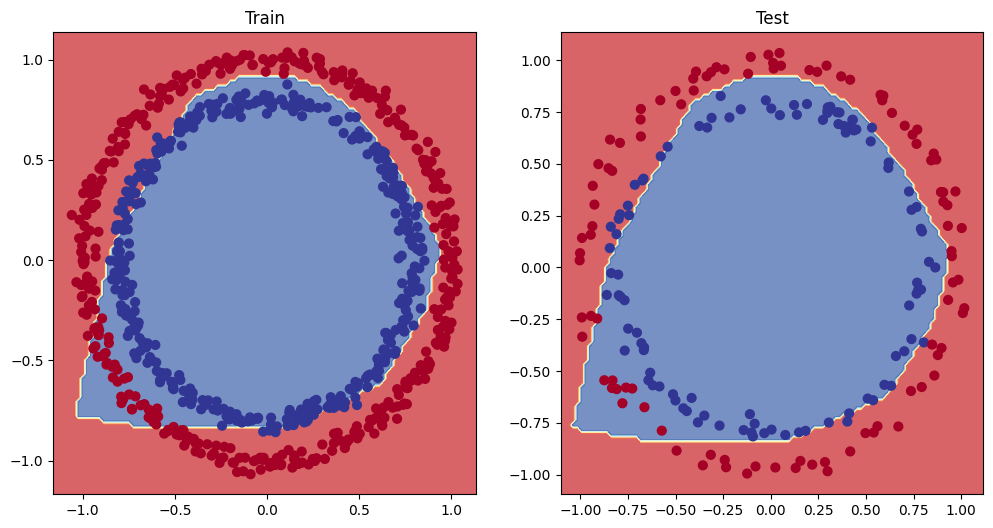

In [31]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.01)

# Training and test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Train
  model_3.train()

  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_train,
                    y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backwards
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Test
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_test,
                      test_pred)

    if epoch % 1000 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test_Loss: {test_loss:.5f}, Test_Acc: {test_acc:.2f}%")

# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [32]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

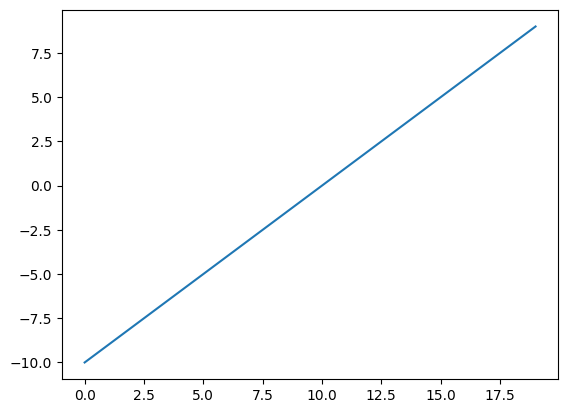

In [33]:
# Visualize
plt.plot(A)

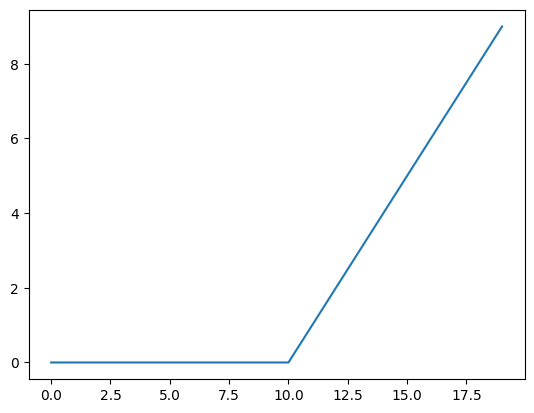

In [34]:
# nn.ReLU() function
def relu(x):
  return torch.max(torch.tensor(0), x)

plt.plot(relu(A))

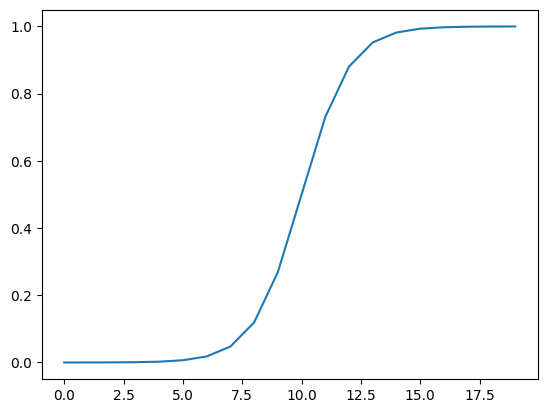

In [35]:
# Sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

## 8. Multiclass classification

### 8.1 Creating a multi-class dataset

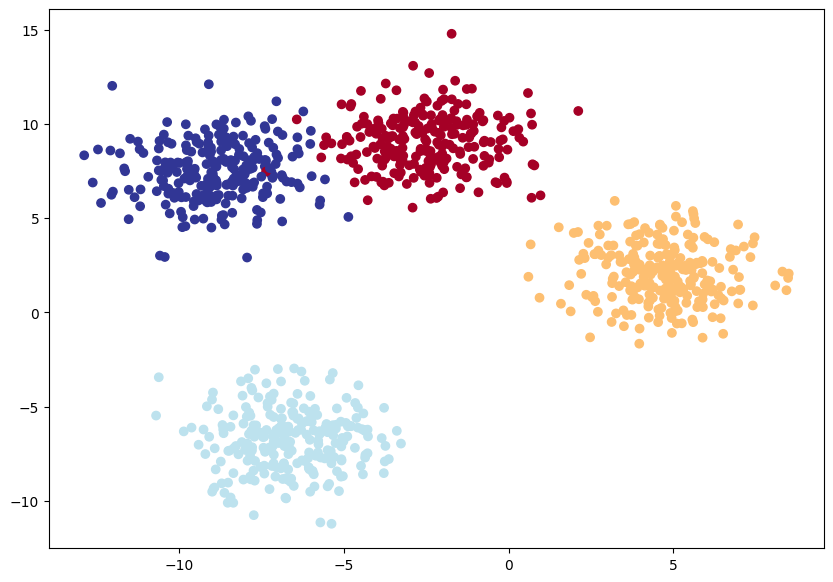

In [36]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                         y_blob,
                                                                         test_size=0.2,
                                                                         random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Multi-class classification model

In [37]:
# Creating device agnostic node
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [55]:
# Build a multi-class model
class BlobModel(nn.Module):
  def __init__(self, intput_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=intput_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_4 = BlobModel(intput_features=2,
                    output_features=4,).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and optimizer for multi-class model

In [56]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr = 0.1)

### 8.4 Getting prediction probabilies for a multi-class model

In [57]:
model_4.eval()
with torch.inference_mode():
  logits = model_4(X_blob_test)

logits[:5], y_blob_test[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]),
 tensor([1, 3, 2, 1, 0]))

In [58]:
model_4.eval()
with torch.inference_mode():
  pred_logits = model_4(X_blob_test)
  pred_probs = torch.softmax(pred_logits, dim=1)

print(pred_probs[:5])

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [59]:
# Convert to prediction labels
y_preds = torch.argmax(pred_probs, dim=1)
y_preds[:5], y_blob_test[:5]

(tensor([1, 0, 0, 0, 0]), tensor([1, 3, 2, 1, 0]))

### 8.5 Train and Testing loop for multiclass

Epoch: 0, Loss: 1.15883, Acc: 40.38%, Test_Loss: 1.07554, Test_Acc: 48.00%
Epoch: 10, Loss: 0.64476, Acc: 96.75%, Test_Loss: 0.66069, Test_Acc: 97.50%
Epoch: 20, Loss: 0.42535, Acc: 98.50%, Test_Loss: 0.43074, Test_Acc: 100.00%
Epoch: 30, Loss: 0.25294, Acc: 99.12%, Test_Loss: 0.24508, Test_Acc: 99.50%
Epoch: 40, Loss: 0.11232, Acc: 99.25%, Test_Loss: 0.10229, Test_Acc: 99.50%
Epoch: 50, Loss: 0.06627, Acc: 99.25%, Test_Loss: 0.05848, Test_Acc: 99.50%
Epoch: 60, Loss: 0.05068, Acc: 99.25%, Test_Loss: 0.04293, Test_Acc: 99.50%
Epoch: 70, Loss: 0.04300, Acc: 99.25%, Test_Loss: 0.03491, Test_Acc: 99.50%
Epoch: 80, Loss: 0.03836, Acc: 99.25%, Test_Loss: 0.02988, Test_Acc: 99.50%
Epoch: 90, Loss: 0.03525, Acc: 99.25%, Test_Loss: 0.02663, Test_Acc: 99.50%


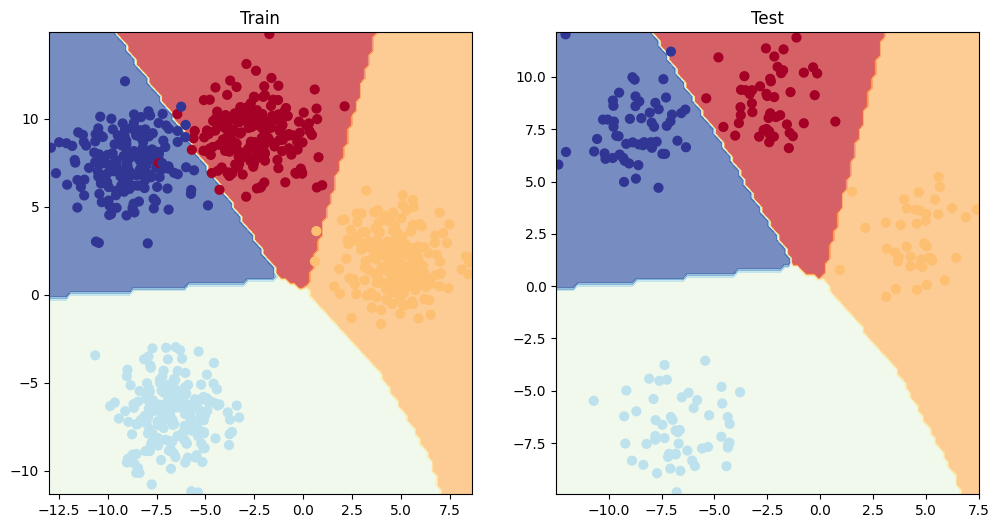

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

model_4.to(device)

for epoch in range(epochs):

  ### Train
  model_4.train()

  # Forward pass
  y_pred_logits = model_4(X_blob_train)
  y_pred_prob = torch.softmax(y_pred_logits, dim=1)
  y_pred_labels = torch.argmax(y_pred_prob, dim=1)

  # Calculate the loss
  loss = loss_fn(y_pred_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train,
                    y_pred_labels)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Test
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_prob = torch.softmax(test_logits, dim=1)
    test_labels = torch.argmax(test_prob, dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test,
                    test_labels)

  if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test_Loss: {test_loss:.5f}, Test_Acc: {test_acc:.2f}%")

# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 8.6 Making and evaluating predictions (torchmetrics)

In [80]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_pred_labels = torch.argmax(y_pred_probs, dim=1)

y_pred_labels[:10]


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

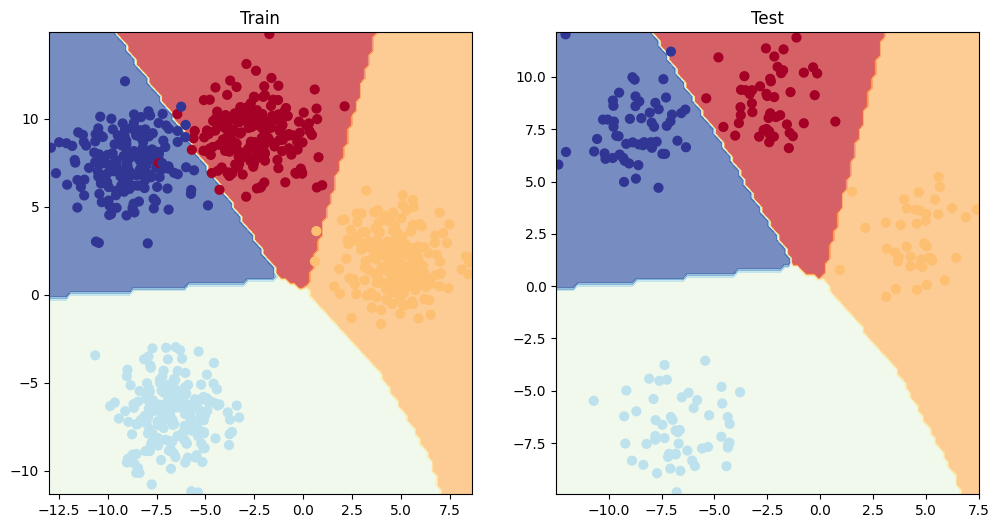

In [81]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Classification metrics

* Accuracy - how many does our model get right
* Precision -
* Recall -
* F1-score -
* Confusion matrix -
* Classification report -



In [82]:
!pip install torchmetrics

In [83]:
import torchmetrics
from torchmetrics import Accuracy

In [84]:
# Setup the metric
metric = Accuracy(task="multiclass", num_classes=4).to(device) # to(device) because is un cpu by default
acc = metric(y_pred_labels, y_blob_test)
acc

tensor(0.9950)